# AutoEncoder - Feature extractor

#Download images

In [1]:
! git clone https://git.wur.nl/manuel.cordovaneira/project_active_learning.git data

Cloning into 'data'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 60 (delta 9), reused 1 (delta 1), pack-reused 23 (from 1)
Receiving objects: 100% (60/60), 486.46 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (6/6), done.


In [2]:
!unzip -q data/images/resizedImages.zip

# Convolutional Autoencoder with Deconvolutions

A convolutional autoencoder using deconvolutional (ConvTranspose2d) layers that compresses an image to a latent space representation.
You can adapt if necessary.

## Imports

In [3]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import os
from PIL import Image

from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Dataloader

In [4]:
# DatasetLoader
class FDWEDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, images, isTrain=True, transforms=None):
        self.images = []
        self.labels = []
        self.transforms = transforms

        for img in images:
          img_path = os.path.join(root_dir, img)
          self.images.append(img_path)
          print(img_path)
          #self.labels.append(img
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = img.convert('RGB')

        # Assertions to check that everything is correct
        assert(isinstance(img, Image.Image)), "Image variable should be a PIL Image"

        if self.transforms is not None:
            img = self.transforms(img)

        return img, img


# Transformations

In [5]:
IMG_MEAN = [0.485, 0.456, 0.406] #image_net values YOU CAN UPDATE THIS IF NEEDED
IMG_STD = [0.229, 0.224, 0.225] #image_net values YOU CAN UPDATE THIS IF NEEDED

def fdwe_transforms(img_size, isTrain=True):

    if isTrain:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
            ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
            ])


# Loading data

In [6]:
#creating two splits
root_dir = 'resizedImages'
list_images = os.listdir(root_dir)
X_train, X_val = train_test_split(list_images, test_size=0.3, random_state=42)# the same images
print(len(X_train))
print(len(X_val))

1551
665


In [7]:
'''
get the labels of data, check the distribution of labels
'''
print(list_images)
full_label=[i.replace('.png', '').split('_')[-1] for i in list_images]
print(full_label)
#shape of full_label
print("length of full_label",len(full_label))
# distribution of full_label
unique, counts = np.unique(full_label, return_counts=True)
print("label count",dict(zip(unique, counts)))

['2021_04_01_wageningen_729_rgb_4.png', '2021_02_25_den_helder_1020_rgb_1.png', '2021_02_25_den_helder_856_rgb_0.png', '2021_02_25_den_helder_282_rgb_1.png', '2021_04_01_wageningen_1073_rgb_0.png', '2021_09_30_den_helder_164_rgb_0.png', '2021_09_30_den_helder_181_rgb_1.png', '2021_04_01_wageningen_732_rgb_1.png', '2021_02_25_den_helder_698_rgb_1.png', '2021_02_25_den_helder_967_rgb_2.png', '2021_02_25_den_helder_90_rgb_0.png', '2021_04_01_wageningen_81_rgb_1.png', '2021_02_25_den_helder_128_rgb_0.png', '2021_04_01_wageningen_798_rgb_0.png', '2021_02_25_den_helder_830_rgb_0.png', '2021_04_30_harlingen_29_rgb_2.png', '2021_04_01_wageningen_1230_rgb_0.png', '2021_02_25_den_helder_973_rgb_1.png', '2021_04_01_wageningen_183_rgb_0.png', '2021_04_30_harlingen_8_rgb_0.png', '2021_09_30_den_helder_347_rgb_1.png', '2021_04_01_wageningen_177_rgb_1.png', '2021_02_25_den_helder_1079_rgb_1.png', '2021_02_25_den_helder_341_rgb_2.png', '2021_09_30_den_helder_497_rgb_0.png', '2021_04_30_harlingen_43_rg

In [8]:
img_size = 224
batch_size = 32

data_transforms_train = fdwe_transforms(img_size)
data_transforms_val = fdwe_transforms(img_size, isTrain=False)
data_transforms_full= fdwe_transforms(img_size, isTrain=False)
# transform datasets to be ready for forward propogation
train_dataset = FDWEDataset(root_dir, X_train, isTrain=True, transforms=data_transforms_train)
val_dataset = FDWEDataset(root_dir, X_val, isTrain=False, transforms=data_transforms_val)


resizedImages/2021_04_30_harlingen_60_rgb_0.png
resizedImages/2021_09_30_den_helder_226_rgb_0.png
resizedImages/2021_02_25_den_helder_687_rgb_3.png
resizedImages/2021_04_30_harlingen_93_rgb_0.png
resizedImages/2021_09_30_den_helder_641_rgb_1.png
resizedImages/2021_09_30_den_helder_156_rgb_0.png
resizedImages/2021_02_25_den_helder_990_rgb_1.png
resizedImages/2021_04_01_wageningen_370_rgb_0.png
resizedImages/2021_02_25_den_helder_1161_rgb_0.png
resizedImages/2021_09_30_den_helder_303_rgb_0.png
resizedImages/2021_09_30_den_helder_372_rgb_1.png
resizedImages/2021_02_25_den_helder_1019_rgb_2.png
resizedImages/2021_09_30_den_helder_668_rgb_0.png
resizedImages/2021_04_01_wageningen_113_rgb_1.png
resizedImages/2021_04_01_wageningen_1076_rgb_0.png
resizedImages/2021_02_25_den_helder_467_rgb_0.png
resizedImages/2021_02_25_den_helder_36_rgb_0.png
resizedImages/2021_04_01_wageningen_1288_rgb_0.png
resizedImages/2021_02_25_den_helder_856_rgb_0.png
resizedImages/2021_04_01_wageningen_56_rgb_0.png
re

In [9]:
print("full_dataset start")
full_dataset=FDWEDataset(root_dir, list_images, isTrain=False, transforms=data_transforms_full)
print("full_dataset end")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

full_dataset start
resizedImages/2021_04_01_wageningen_729_rgb_4.png
resizedImages/2021_02_25_den_helder_1020_rgb_1.png
resizedImages/2021_02_25_den_helder_856_rgb_0.png
resizedImages/2021_02_25_den_helder_282_rgb_1.png
resizedImages/2021_04_01_wageningen_1073_rgb_0.png
resizedImages/2021_09_30_den_helder_164_rgb_0.png
resizedImages/2021_09_30_den_helder_181_rgb_1.png
resizedImages/2021_04_01_wageningen_732_rgb_1.png
resizedImages/2021_02_25_den_helder_698_rgb_1.png
resizedImages/2021_02_25_den_helder_967_rgb_2.png
resizedImages/2021_02_25_den_helder_90_rgb_0.png
resizedImages/2021_04_01_wageningen_81_rgb_1.png
resizedImages/2021_02_25_den_helder_128_rgb_0.png
resizedImages/2021_04_01_wageningen_798_rgb_0.png
resizedImages/2021_02_25_den_helder_830_rgb_0.png
resizedImages/2021_04_30_harlingen_29_rgb_2.png
resizedImages/2021_04_01_wageningen_1230_rgb_0.png
resizedImages/2021_02_25_den_helder_973_rgb_1.png
resizedImages/2021_04_01_wageningen_183_rgb_0.png
resizedImages/2021_04_30_harling

In [10]:
from torchvision.transforms import ToPILImage

to_PIL_transform = ToPILImage()

#This function is needed because of using mean and std from ImageNet dataset
def denormalize(image, mean=IMG_MEAN, std=IMG_STD):
    image = image.clone()
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(image, 0, 1)

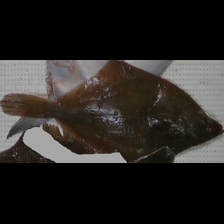

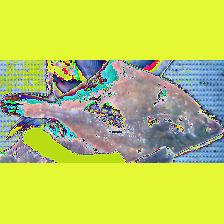

In [11]:
#plot a sample denormalize
img,_ = val_dataset[12]
curr_img = img_new = denormalize(img)
img_show = to_PIL_transform(curr_img)
display(img_show)

#plot a sample after using imagenet normalization
img,_ = val_dataset[12]
img_show = to_PIL_transform(img)
display(img_show)


## Model

In [12]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, latent_variable_size):
        super(ConvolutionalAutoencoder, self).__init__()

        #Encoder
        self.conv_1 = torch.nn.Conv2d(in_channels=3,
                                      out_channels=16,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      bias=False)


        self.conv_2 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      bias=False)

        self.bn1 = nn.BatchNorm2d(32)

        self.conv_3 = torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1,
                                      bias=False)

        self.bn2 = nn.BatchNorm2d(64)

        self.conv_4 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=3,
                                      stride=2,
                                      padding=1)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.fc1 = nn.Linear(2048 , latent_variable_size)

        self.flatten = nn.Flatten()

        #Decoder
        self.fc3 = nn.Linear(latent_variable_size, 2048)
        self.fc4 = nn.Linear(2048, 14*14*32)


        self.deconv_1 = torch.nn.ConvTranspose2d(in_channels=32,
                                                 out_channels=64,
                                                 kernel_size=3,
                                                 stride=2,
                                                 padding=1,
                                                 output_padding=1)

        self.deconv_2 = torch.nn.ConvTranspose2d(in_channels=64,
                                                 out_channels=32,
                                                 kernel_size=3,
                                                 stride=2,
                                                 padding=1,
                                                 output_padding=1)

        self.deconv_3 = torch.nn.ConvTranspose2d(in_channels=32,
                                                 out_channels=16,
                                                 kernel_size=3,
                                                 stride=2,
                                                 padding=1,
                                                 output_padding=1)

        self.deconv_4 = torch.nn.ConvTranspose2d(in_channels=16,
                                                 out_channels=3,
                                                 kernel_size=3,
                                                 stride=2,
                                                 padding=1,
                                                 output_padding=1)


        self.flatten = torch.nn.Flatten()

    def encoder(self, x, isTrain=True):
        h = self.conv_1(x)
        h = F.leaky_relu(h)
        h = self.conv_2(h)
        h = self.bn1(h)
        h = self.conv_3(h)
        h = self.bn2(h)
        h = self.conv_4(h)
        h = F.leaky_relu(h)
        h = self.avgpool(h)
        h = self.flatten(h)
        z = self.fc1(h)

        return z

    def decoder(self, x):
        h = self.fc3(x)
        h = F.leaky_relu(h)
        h = self.fc4(h)
        h = F.leaky_relu(h)
        h = h.view(-1,32,14,14)
        h = self.deconv_1(h)
        h = F.leaky_relu(h)
        h = self.deconv_2(h)
        h = F.leaky_relu(h)
        h = self.deconv_3(h)
        h = F.leaky_relu(h)
        h = self.deconv_4(h)
        xhat = F.leaky_relu(h)
        return xhat

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)

        return xhat, self.flatten(z)

## Training

In [13]:
from torch.optim.lr_scheduler import StepLR

def train_autoencoder(model, train_loader, num_epochs, loss, optimizer):
  model.train()
  scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
  for epoch in range(num_epochs):
    for batch_idx, (images, targets) in enumerate(train_loader):

        images = images.to(device)

        ### FORWARD AND BACK PROP
        decoded, _ = model(images)
        cost = loss(decoded, images)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), cost))

    scheduler.step()

In [14]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda:0


In [15]:
# Hyperparameters
seed = 2024
learning_rate = 0.005
num_epochs = 100

torch.manual_seed(seed)

In [16]:
#train a model
latent_space_features = 20
model = ConvolutionalAutoencoder(latent_space_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.MSELoss()

train_autoencoder(model, train_loader, num_epochs, loss, optimizer)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 001/100 | Batch 000/048 | Loss: 2.0556
Epoch: 002/100 | Batch 000/048 | Loss: 1.0162
Epoch: 003/100 | Batch 000/048 | Loss: 0.7116
Epoch: 004/100 | Batch 000/048 | Loss: 0.5847
Epoch: 005/100 | Batch 000/048 | Loss: 0.6076
Epoch: 006/100 | Batch 000/048 | Loss: 0.4690
Epoch: 007/100 | Batch 000/048 | Loss: 0.5666
Epoch: 008/100 | Batch 000/048 | Loss: 0.4652
Epoch: 009/100 | Batch 000/048 | Loss: 0.3889
Epoch: 010/100 | Batch 000/048 | Loss: 0.3782
Epoch: 011/100 | Batch 000/048 | Loss: 0.5806
Epoch: 012/100 | Batch 000/048 | Loss: 0.4108
Epoch: 013/100 | Batch 000/048 | Loss: 0.3837
Epoch: 014/100 | Batch 000/048 | Loss: 0.3606
Epoch: 015/100 | Batch 000/048 | Loss: 0.3184
Epoch: 016/100 | Batch 000/048 | Loss: 0.3355
Epoch: 017/100 | Batch 000/048 | Loss: 0.3332
Epoch: 018/100 | Batch 000/048 | Loss: 0.3346
Epoch: 019/100 | Batch 000/048 | Loss: 0.4422
Epoch: 020/100 | Batch 000/048 | Loss: 0.2993
Epoch: 021/100 | Batch 000/048 | Loss: 0.2972
Epoch: 022/100 | Batch 000/048 | L

## Evaluation

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def plot_grid(imgs, nrows, ncols, fig_size=(10.0, 10.0)):
    """
    This function plots a grid of images using the given list of images.
    The grid has the specified number of rows and columns.

    Parameters:
        - imgs (List[PIL.Image]): a list of PIL.Image objects to plot
        - nrows (int): the number of rows in the grid
        - ncols (int): the number of columns in the grid

    Returns:
        None.
    """
    assert len(imgs) == nrows * ncols, f"nrows*ncols must be equal to the number of images"
    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=(nrows, ncols),
        axes_pad=0.1,  # pad between axes in inch.
    )
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    fig.text(0,0.53,"Original \n Images",weight='bold', size=15)
    fig.text(0,0.45,"Reconstructed \n Images",weight='bold',size=15)
    plt.show()

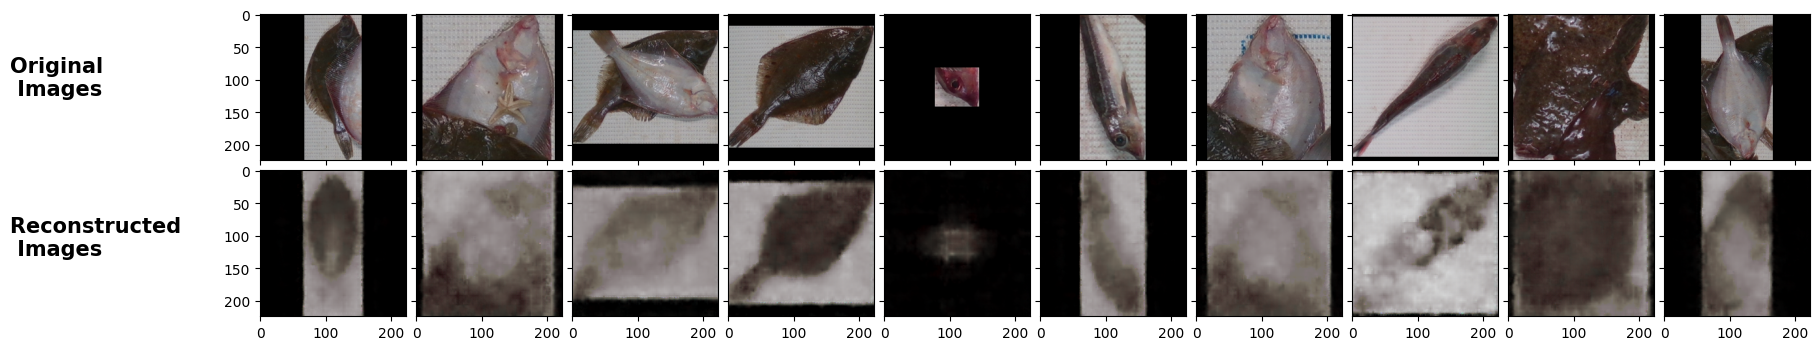

In [18]:
#PLOT some images
model.eval()
# Let's select 10 images and pass them through our network
n_images = 10
imgs = [val_dataset[idx][0] for idx in range(n_images)]
original_imgs = []
reconstructed_imgs = []

for img in imgs:
    img = img.to(device)[None,:] #adding bacth dimension
    pred, _ = model(img)

    ## Convert img from tensor to PIL image format

    #Use this if you use image MEAN and STD of the evaluated dataset
    #pred = to_PIL_transform(pred[0].detach())
    #img = to_PIL_transform(img[0].detach())

    #If you use ImageNet mean and std, use this code to apply denormalization
    img = denormalize(img[0].detach())
    pred = denormalize(pred[0].detach())
    pred = to_PIL_transform(pred)
    img = to_PIL_transform(img)

    # Add images to list
    original_imgs.append(img)
    reconstructed_imgs.append(pred)

# Plot the results
original_imgs += reconstructed_imgs
plot_grid(imgs=original_imgs, nrows=2, ncols=(len(original_imgs)//2), fig_size=(20,20))


# Get features from the latent space

In [19]:
def get_latent_space_features(model, dataset):
  model.eval()
  latent_space_features = []
  for img, target in dataset:
    img = img.to(device)[None,:]
    _, features = model(img)

    img_features = features.detach().cpu().numpy().tolist()[0]
    latent_space_features.append(img_features)

  return latent_space_features

In [20]:
for i in range(len(full_dataset.images)):
  print(full_dataset.images[i])

resizedImages/2021_04_01_wageningen_729_rgb_4.png
resizedImages/2021_02_25_den_helder_1020_rgb_1.png
resizedImages/2021_02_25_den_helder_856_rgb_0.png
resizedImages/2021_02_25_den_helder_282_rgb_1.png
resizedImages/2021_04_01_wageningen_1073_rgb_0.png
resizedImages/2021_09_30_den_helder_164_rgb_0.png
resizedImages/2021_09_30_den_helder_181_rgb_1.png
resizedImages/2021_04_01_wageningen_732_rgb_1.png
resizedImages/2021_02_25_den_helder_698_rgb_1.png
resizedImages/2021_02_25_den_helder_967_rgb_2.png
resizedImages/2021_02_25_den_helder_90_rgb_0.png
resizedImages/2021_04_01_wageningen_81_rgb_1.png
resizedImages/2021_02_25_den_helder_128_rgb_0.png
resizedImages/2021_04_01_wageningen_798_rgb_0.png
resizedImages/2021_02_25_den_helder_830_rgb_0.png
resizedImages/2021_04_30_harlingen_29_rgb_2.png
resizedImages/2021_04_01_wageningen_1230_rgb_0.png
resizedImages/2021_02_25_den_helder_973_rgb_1.png
resizedImages/2021_04_01_wageningen_183_rgb_0.png
resizedImages/2021_04_30_harlingen_8_rgb_0.png
resi

In [25]:
features = get_latent_space_features(model, val_dataset)
feature_output = os.path.join('data/', 'features_665_20_val_dataset.npy')
np.save(feature_output, features)
features_full_set = get_latent_space_features(model, full_dataset)
feature_output_full_set = os.path.join('data/', 'features_2216_20.npy')
np.save(feature_output_full_set, features_full_set)

In [26]:
# prompt: keep only the first column and last two columns of data/crop_features/fish_features_pca.npy

import numpy as np
# Load the data
data_labels = np.load("data/crop_features/fish_features_pca.npy")

# Keep only the first column and last two columns
data_labels = data_labels[:, [0, -2, -1]]

print(data_labels)


[['2021_02_25_den_helder_1000_rgb_0.png' '0' '0.091']
 ['2021_02_25_den_helder_1000_rgb_1.png' '0' '0.102']
 ['2021_02_25_den_helder_1002_rgb_0.png' '0' '0.091']
 ...
 ['2021_09_30_den_helder_96_rgb_0.png' '8' '0.534']
 ['2021_09_30_den_helder_97_rgb_0.png' '8' '0.657']
 ['2021_09_30_den_helder_99_rgb_0.png' '8' '0.584']]


In [27]:
for i in range(len(list_images)):
  print(list_images[i])

2021_04_01_wageningen_729_rgb_4.png
2021_02_25_den_helder_1020_rgb_1.png
2021_02_25_den_helder_856_rgb_0.png
2021_02_25_den_helder_282_rgb_1.png
2021_04_01_wageningen_1073_rgb_0.png
2021_09_30_den_helder_164_rgb_0.png
2021_09_30_den_helder_181_rgb_1.png
2021_04_01_wageningen_732_rgb_1.png
2021_02_25_den_helder_698_rgb_1.png
2021_02_25_den_helder_967_rgb_2.png
2021_02_25_den_helder_90_rgb_0.png
2021_04_01_wageningen_81_rgb_1.png
2021_02_25_den_helder_128_rgb_0.png
2021_04_01_wageningen_798_rgb_0.png
2021_02_25_den_helder_830_rgb_0.png
2021_04_30_harlingen_29_rgb_2.png
2021_04_01_wageningen_1230_rgb_0.png
2021_02_25_den_helder_973_rgb_1.png
2021_04_01_wageningen_183_rgb_0.png
2021_04_30_harlingen_8_rgb_0.png
2021_09_30_den_helder_347_rgb_1.png
2021_04_01_wageningen_177_rgb_1.png
2021_02_25_den_helder_1079_rgb_1.png
2021_02_25_den_helder_341_rgb_2.png
2021_09_30_den_helder_497_rgb_0.png
2021_04_30_harlingen_43_rgb_0.png
2021_02_25_den_helder_1151_rgb_4.png
2021_04_01_wageningen_575_rgb_1.

In [28]:
f_full = np.load('data/features_2216_20.npy')
# First, we create a dictionary to map names to their original indices in data_labels
name_to_index = {name: idx for idx, name in enumerate(data_labels[:, 0])}
print(name_to_index)
# Now, retrieve the indices for the shuffled names in list_images
indices = [name_to_index[name] for name in list_images]
print(indices)
# Use these indices to retrieve the corresponding rows from data_labels
retrieved_rows = data_labels[indices]
print(retrieved_rows)


{'2021_02_25_den_helder_1000_rgb_0.png': 0, '2021_02_25_den_helder_1000_rgb_1.png': 1, '2021_02_25_den_helder_1002_rgb_0.png': 2, '2021_02_25_den_helder_1002_rgb_1.png': 3, '2021_02_25_den_helder_1003_rgb_0.png': 4, '2021_02_25_den_helder_1003_rgb_1.png': 5, '2021_02_25_den_helder_1003_rgb_2.png': 6, '2021_02_25_den_helder_1006_rgb_0.png': 7, '2021_02_25_den_helder_1006_rgb_1.png': 8, '2021_02_25_den_helder_1008_rgb_0.png': 9, '2021_02_25_den_helder_1008_rgb_1.png': 10, '2021_02_25_den_helder_1010_rgb_0.png': 11, '2021_02_25_den_helder_1010_rgb_1.png': 12, '2021_02_25_den_helder_1010_rgb_2.png': 13, '2021_02_25_den_helder_1013_rgb_0.png': 14, '2021_02_25_den_helder_1013_rgb_1.png': 15, '2021_02_25_den_helder_1015_rgb_0.png': 16, '2021_02_25_den_helder_1015_rgb_1.png': 17, '2021_02_25_den_helder_1017_rgb_0.png': 18, '2021_02_25_den_helder_1017_rgb_1.png': 19, '2021_02_25_den_helder_1017_rgb_2.png': 20, '2021_02_25_den_helder_1019_rgb_0.png': 21, '2021_02_25_den_helder_1019_rgb_1.png': 2

In [29]:

for row in retrieved_rows:
    if row[0] == '2021_02_25_den_helder_1000_rgb_0.png':
        print(row)
    if row[0] == '2021_02_25_den_helder_1000_rgb_1.png':
        print(row)
    if row[0] == '2021_09_30_den_helder_99_rgb_0.png':
        print(row)
print("data in data_labels")
for row in data_labels:
    if row[0] == '2021_02_25_den_helder_1000_rgb_0.png':
        print(row)
    if row[0] == '2021_02_25_den_helder_1000_rgb_1.png':
        print(row)
    if row[0] == '2021_09_30_den_helder_99_rgb_0.png':
        print(row)

['2021_02_25_den_helder_1000_rgb_1.png' '0' '0.102']
['2021_09_30_den_helder_99_rgb_0.png' '8' '0.584']
['2021_02_25_den_helder_1000_rgb_0.png' '0' '0.091']
data in data_labels
['2021_02_25_den_helder_1000_rgb_0.png' '0' '0.091']
['2021_02_25_den_helder_1000_rgb_1.png' '0' '0.102']
['2021_09_30_den_helder_99_rgb_0.png' '8' '0.584']


In [31]:
# prompt: concatenate f_full with the last_two_columns
f_full = np.load('data/features_2216_20.npy')
f_full = np.concatenate((f_full, retrieved_rows[:, -2:]), axis=1)
f_full=np.concatenate((retrieved_rows[:, 0].reshape(-1,1),f_full),axis=1)
print(f_full)
np.save('data/features_2216_20_with_labels.npy', f_full)
print(f_full.shape)

[['2021_04_01_wageningen_729_rgb_4.png' '-150.977783203125'
  '-8.50101089477539' ... '-6.113364219665527' '3' '0.069']
 ['2021_02_25_den_helder_1020_rgb_1.png' '-308.3819885253906'
  '15.951305389404297' ... '-44.69617462158203' '0' '0.149']
 ['2021_02_25_den_helder_856_rgb_0.png' '-38.18626022338867'
  '138.0391387939453' ... '-35.400657653808594' '0' '0.083']
 ...
 ['2021_09_30_den_helder_373_rgb_0.png' '-208.9089813232422'
  '7.22469425201416' ... '23.19423484802246' '7' '0.11']
 ['2021_04_01_wageningen_212_rgb_1.png' '-155.05551147460938'
  '-0.9357279539108276' ... '-47.89567947387695' '1' '0.157']
 ['2021_02_25_den_helder_13_rgb_0.png' '-79.65957641601562'
  '-15.065201759338379' ... '130.08840942382812' '0' '0.115']]
(2216, 23)
